# crop 된 이미지를 유사한 특성이 가진 1:1 크기의 파일로 변경

- gray 스케일로 할지 안할지...



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

from tqdm import tqdm

import os
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
## 이미지 파일 불러오는 함수

# 세부 디렉토리 이름 가져오기
def load_image_path(dir):
    food_middle_list = sorted(os.listdir(dir))
    food_list = []  # 음식 이름
    food_path_list = []  # 음식 이름 경로

    for food_middle in food_middle_list:
        middle_path = os.path.join(dir, food_middle)
        food_name_list = os.listdir(middle_path)

        for food in food_name_list:
            path = os.path.join(middle_path, food)
            food_path_list.append(path)
            name = path.split('/')[-1]
            food_list.append(name)

    return food_list, food_path_list

# 세부 디렉토리의 이미지 파일 이름 가져오기
def get_all_image_files(dir):
    img_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    image_files = []

    for root, _, files in os.walk(dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in img_extensions):
                image_files.append(os.path.join(root, file))

    return image_files

In [5]:
raw_dir = '/content/drive/MyDrive/project3/data/traindata/train_image_crop'
food_list, food_path_list = load_image_path(raw_dir)
image_path = get_all_image_files(food_path_list[0])

print(len(food_list))
print(food_list)
print(food_path_list)
print(image_path[:5])

1
['갈치구이']
['/content/drive/MyDrive/project3/data/traindata/train_image_crop/구이/갈치구이']
['/content/drive/MyDrive/project3/data/traindata/train_image_crop/구이/갈치구이/Img_001_0002_crop.jpg', '/content/drive/MyDrive/project3/data/traindata/train_image_crop/구이/갈치구이/Img_001_0006_crop.jpg', '/content/drive/MyDrive/project3/data/traindata/train_image_crop/구이/갈치구이/Img_001_0007_crop.jpg', '/content/drive/MyDrive/project3/data/traindata/train_image_crop/구이/갈치구이/Img_001_0008_crop.jpg', '/content/drive/MyDrive/project3/data/traindata/train_image_crop/구이/갈치구이/Img_001_0011_crop.jpg']


## 그림을 정사각형으로 바꾸고자 한다.
1. 1:1형태의 patch를 만든다.
    - 지금은 width, height 중 짧은 축
    - (width, height 중 짧은 축을 기준으로 20pixel 작은)
2. patch를 x축 / y축으로 20씩 이동시켜서 histgram을 그리고
3. 원본의 histogram과 유사한 patch를 선택
4. 이를 새로운 이미지로 저장
    - 컬러 / gray 2가지 방식으로 patch를 선택하고,
    - 두 경우 다 저장


In [20]:
# histogram 그리기
def calculate_histogram(image):
    # Gray Scale 일떄
    if len(image.shape) == 2:
        histogram = cv2.calcHist([image], # 이미지
                                 [0], # 사용될 채널
                                 None, # 마스크
                                 [256], #bins
                                 [0, 256]) #각 채널의 최소값 / 최대값
    else:  # 컬러 이미지
        histogram = cv2.calcHist([image],
                                 [0, 1, 2],
                                 None,
                                 [256, 256, 256],
                                 [0, 256, 0, 256, 0, 256])

    # 히스토그램 정규화
    cv2.normalize(histogram, histogram)
    return histogram


# 원본과 가장 비슷한 hist를 갖는 그림을 선정
def find_best_match(image, target_hist, patch_size):

    # 가장 비슷한 사이즈를 정하기 위한 준비
    min_diff = float('inf')
    best_x, best_y = 0, 0

    # 이미지 크기
    # Gray Scale 일떄
    if len(image.shape) == 2:
        height, width = image.shape
    # 컬러 이미지
    else:
        height, width, _ = image.shape
    # patch의 위치를 20씩 이동시키며 비교
    for y in range(0, height - patch_size, 20):
        for x in range(0, width - patch_size, 20):
            patch = image[y:y + patch_size, x:x + patch_size]
            patch_hist = calculate_histogram(patch)
            diff = cv2.compareHist(target_hist, patch_hist, cv2.HISTCMP_BHATTACHARYYA)
            if diff < min_diff:
                min_diff = diff
                best_x, best_y = x, y

    return best_x, best_y

def extract_best_patch(image):

    image_size_adj = 20

    # gray로 판별하는 방법
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height_g, width_g = image_gray.shape
    patch_size_g = min(height_g - image_size_adj, width_g - image_size_adj)  # 1:1 비율의 패치 크기 결정(원본보다 20 작게)
    target_hist_g = calculate_histogram(image_gray)

    best_x_g, best_y_g = find_best_match(image_gray, target_hist_g, patch_size_g)
    best_patch_gray = image[best_y_g:best_y_g + patch_size_g, best_x_g:best_x_g + patch_size_g]


    # color로 판별
    height, width, _ = image.shape

    patch_size = min(height -image_size_adj, width - image_size_adj)  # 1:1 비율의 패치 크기 결정(원본보다 20 작게)
    target_hist = calculate_histogram(image)  # 원본 이미지의 히스토그램 계산

    best_x, best_y = find_best_match(image, target_hist, patch_size)
    best_patch_color = image[best_y:best_y + patch_size, best_x:best_x + patch_size]

    return best_patch_gray, best_patch_color


원본


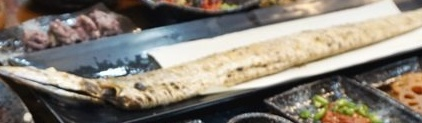

gray 이미지로 선택


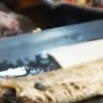

컬러 이미지로 선택


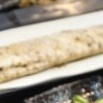

In [17]:
pic_num = 55
test_images = get_all_image_files(food_path_list[0])
test_image_path = test_images[pic_num]
test_image = cv2.imread(test_image_path)

# 원본
print('원본')
cv2_imshow(test_image)
# gray 이미지로 선택하기
print('gray 이미지로 선택')
cv2_imshow(extract_best_patch(test_image)[0])
# 컬러 이미지로 선택하기
print('컬러 이미지로 선택')
cv2_imshow(extract_best_patch(test_image)[1])


In [23]:
# 최선의 그림을 찾아서 저장하기
def select_best_patch_image(raw_image_path):

    # 디렉토리 생성
    color_image_path = raw_image_path.replace('kfood', 'selected_image_color')
    if not os.path.exists(color_image_path):
        os.makedirs(color_image_path)

    gray_image_path = raw_image_path.replace('kfood', 'selected_image_gray')
    if not os.path.exists(gray_image_path):
        os.makedirs(gray_image_path)

    images_path = get_all_image_files(raw_image_path)
    print(raw_image_path)
    for image_path in tqdm(images_path):
        img = cv2.imread(image_path)
        if img is not None:

            best_patch_gray = extract_best_patch(img)[0]
            best_patch_color = extract_best_patch(img)[1]

            # extract_best_patch(img[0]) -> gray hist로 선택
            # gray_select 만들기
            output_gray_image = best_patch_gray
            output_gray_image_path = image_path.replace('kfood', 'selected_image_gray').replace('Img', 'select_gray')

            # 저장하기
            cv2.imwrite(output_gray_image_path, output_gray_image)

            # extract_best_patch(img[1]) -> color hist로 선택
            # color_select 만들기
            output_color_image = best_patch_color
            output_color_image_path = image_path.replace('kfood', 'selected_image_color').replace('Img', 'select_color')

            # color 저장하기
            cv2.imwrite(output_color_image_path, output_color_image)





In [24]:
raw_dir = '/content/drive/MyDrive/project3/data/traindata/kfood'
food_list, food_path_list = load_image_path(raw_dir)

for food_path in (food_path_list[:1]):
    select_best_patch_image(food_path)


/content/drive/MyDrive/project3/data/traindata/kfood/구이/갈비구이


100%|██████████| 1000/1000 [13:22<00:00,  1.25it/s]


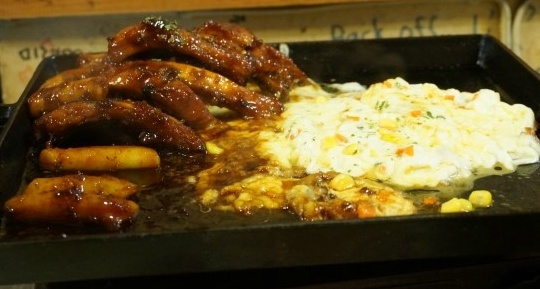

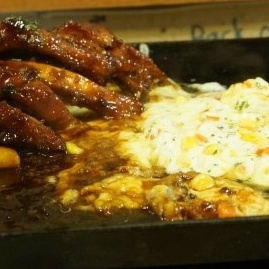

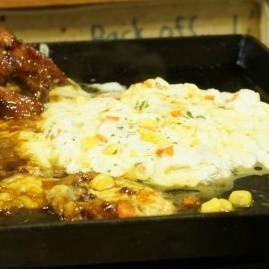

In [36]:
pic_num = 25
for path in ['kfood', 'selected_image_color', 'selected_image_gray']:
    images = get_all_image_files(f'/content/drive/MyDrive/project3/data/traindata/{path}/구이/갈비구이')
    image = images[pic_num]
    img = cv2.imread(image)
    cv2_imshow(img)


In [31]:
images

[]